# Trabalho da disciplina Fundamentos de Inteligência Artificial

Avaliar um conjunto de classificadores (no mínimo 3) dentro de um problema específico. Para tal, deve ser entregue um resumo estendido (artigo de, no máximo, 2 páginas). O artigo deve conter:
1 – Uma introdução do problema;
2 – Metodologia, falando quais algoritmos serão utilizados e qual o dataset (junto com a sua descrição) e o protocolo de testes;
3 – Resultados, uma tabela comparando os resultados dos algoritmos;
4 – Conclusões, suas conclusões com base no resultado.

## Referências

- <https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data>
- <https://www.kaggle.com/code/ismaelelhussein/ecg-classification-ml-dl-comparative-study>
- <https://www.physionet.org/content/mitdb/1.0.0/>

## Descrição do domínio



## Importa dependências

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate
import matplotlib.pyplot as plt

## Carrega o dataset

> O dataset já vem separado em dataset de treino e dataset de teste

In [43]:
train_df = pd.read_csv('../datasets/ecg/mitbih_train.csv', header=None)
test_df = pd.read_csv('../datasets/ecg/mitbih_test.csv', header=None)

## Prepara o dataset

### Assumindo que as classes estão na ultima coluna do dataset

In [44]:
classes_column_index = train_df.shape[1] - 1

### Obtém valores únicos na coluna `classes`

In [45]:
class_labels = train_df[classes_column_index].unique()

### Atribui nomes significativos aos rótulos de classe com base no conhecimento do domínio

In [46]:
class_names = {
    0: "Batidas normais",
    1: "Batidas de Ectopia Supraventricular",
    2: "Batidas de Ectopia Ventricular",
    3: "Batidas de fusão",
    4: "Batidas Inclassificáveis"
}

### Imprime valores (inteiros) de classes com respectivos nomes atribuídos

In [47]:
#for label in class_labels:
#    print(f"Class label {label}: {class_names[label]}")

### Explora o dataset

In [48]:
print("Columns and their NaN percentages:")
null_col = train_df.isna().mean() * 100
print(null_col)

Columns and their NaN percentages:
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
183    0.0
184    0.0
185    0.0
186    0.0
187    0.0
Length: 188, dtype: float64


### Altera o tipo de dados para `float` e obtém os valores únicos na última coluna para ver quantas linhas há em cada classe, armazena-a na variável `equilíbrio` e imprime

In [49]:
train_df[187] = train_df[187].astype(float)
equilibre = train_df[187].value_counts()
print(equilibre)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [50]:
test_df[187] = test_df[187].astype(float)
equilibre = test_df[187].value_counts()
print(equilibre)

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


### Mostra informações do dataset

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


### Obtém a média em todas as colunas

In [53]:
# Assuming you loaded the data into a DataFrame named 'data'
column_means = train_df.mean()
print(column_means)

0      0.890360
1      0.758160
2      0.423972
3      0.219104
4      0.201127
         ...   
183    0.003471
184    0.003221
185    0.002945
186    0.002807
187    0.473376
Length: 188, dtype: float64


### Mostra um gráfico de rosca que explica cada classe com suas porcentagens no dataset

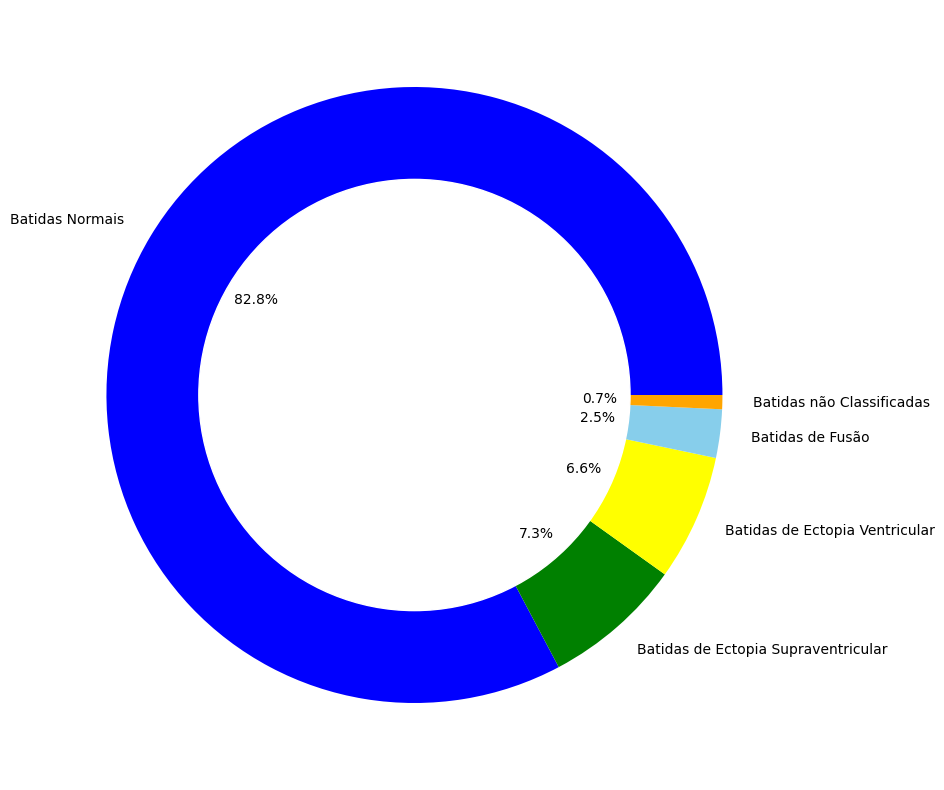

In [54]:
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre, labels=['Batidas Normais', 'Batidas de Ectopia Supraventricular', 'Batidas de Ectopia Ventricular', 'Batidas de Fusão', 'Batidas não Classificadas'], colors=[
        'Blue', 'Green', 'Yellow', 'Skyblue', 'Orange'], autopct='%1.1f%%', textprops={'color': 'black'})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Tenta evitar o *overfitting*

#### Reamostra os dados para 20.000 amostras de cada classe para torná-lo mais equilibrado para trabalhar com classificação, pois a classe de batidas normais contém muito mais amostras do que as outras e isso pode levar a um desequilíbrio no modelo e ao *overfitting*

In [55]:
from sklearn.utils import resample
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]

df_1_upsample = resample(df_1, n_samples=20000, replace=True, random_state=123)
df_2_upsample = resample(df_2, n_samples=20000, replace=True, random_state=123)
df_3_upsample = resample(df_3, n_samples=20000, replace=True, random_state=123)
df_4_upsample = resample(df_4, n_samples=20000, replace=True, random_state=123)
df_0 = train_df[train_df[187] == 0].sample(n=20000, random_state=123)
train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [56]:
df_1_t = test_df[test_df[187] == 1]
df_2_t = test_df[test_df[187] == 2]
df_3_t = test_df[test_df[187] == 3]
df_4_t = test_df[test_df[187] == 4]

df_1_upsample_t = resample(df_1, n_samples=5000, replace=True, random_state=123)
df_2_upsample_t = resample(df_2, n_samples=5000, replace=True, random_state=123)
df_3_upsample_t = resample(df_3, n_samples=5000, replace=True, random_state=123)
df_4_upsample_t = resample(df_4, n_samples=5000, replace=True, random_state=123)
df_0_t = test_df[test_df[187] == 0].sample(n=5000, random_state=123)
test_df = pd.concat([df_0_t, df_1_upsample_t, df_2_upsample_t, df_3_upsample_t, df_4_upsample_t])

#### Os gráficos de rosca mostram o dataset após a reamostragem

DATASET DE TREINAMENTO


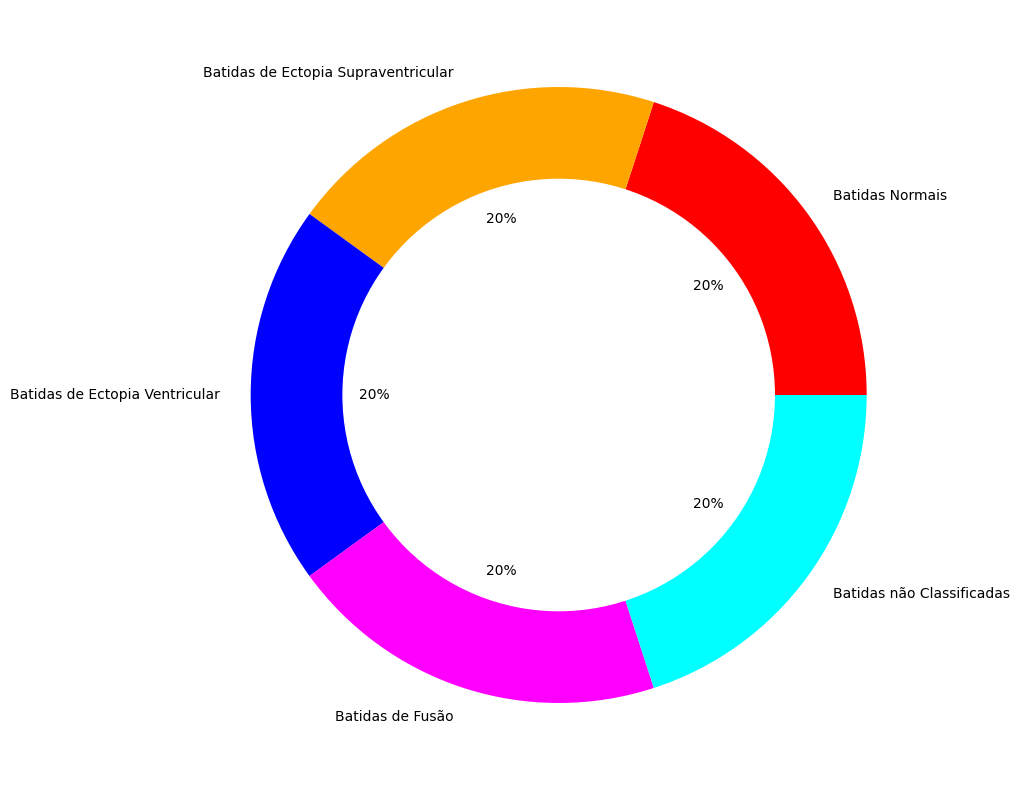

In [57]:
plt.figure(figsize=(10, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_df[187].value_counts(), labels=['Batidas Normais', 'Batidas de Ectopia Supraventricular', 'Batidas de Ectopia Ventricular',
        'Batidas de Fusão', 'Batidas não Classificadas'], autopct='%0.0f%%', colors=['red', 'orange', 'blue', 'magenta', 'cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
print("DATASET DE TREINAMENTO")
plt.show()

DATASET DE TESTE


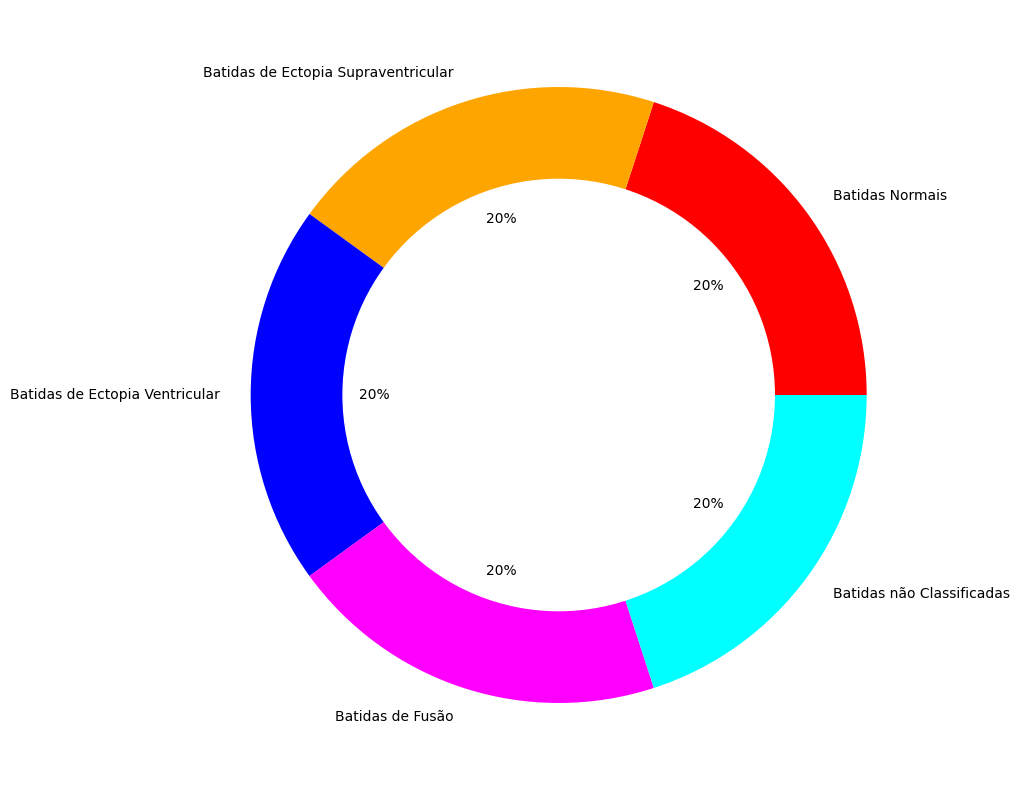

In [58]:
plt.figure(figsize=(10, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(test_df[187].value_counts(), labels=['Batidas Normais', 'Batidas de Ectopia Supraventricular', 'Batidas de Ectopia Ventricular', 'Batidas de Fusão', 'Batidas não Classificadas'], autopct='%0.0f%%', colors=['red', 'orange', 'blue', 'magenta', 'cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
print("DATASET DE TESTE")
plt.show()

#### Certifica que a reamostragem do dataset funciona

In [59]:
print(train_df[187].value_counts())
print(len(train_df[187].value_counts()))

187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64
5


### Pré-processamento

1. Com a última coluna (187), são os recursos que contêm todas as classes, nós os dividimos em recursos e rótulos no dataset

In [60]:
x_train = train_df.drop(columns=[187])
y_train = train_df[187]

- Filtro passa-baixo: Um filtro passa-baixo permite que sinais abaixo de uma determinada frequência de corte passem sem serem afetados enquanto atenua frequências acima do corte. No contexto dos sinais de ECG, ajuda a remover ruídos de alta frequência, preservando ao mesmo tempo os importantes componentes de baixa frequência relacionados à atividade cardíaca.
- Função butter_lowpass_filter: Esta função encapsula o processo de design e aplicação do filtro passa-baixa Butterworth. Ele pega parâmetros como frequência de corte, taxa de amostragem e ordem do filtro e retorna o sinal filtrado.***

In [61]:
from scipy.signal import butter, filtfilt

ecg_data = train_df
ecg_signal = x_train
class_labels = y_train
sampling_rate = 125


def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Example usage:
cutoff_frequency = 50  # Define the cutoff frequency in Hz
filtered_ecg_signal = butter_lowpass_filter(ecg_signal, cutoff_frequency, sampling_rate)

2. Dividir o dataset em treinamento e validação para usá-los em modelos de máquina
3. Usar o conjunto de dados testin para separar também em recursos e rótulos
4. Usar a função de escalador padrão para normalizar o dataset de treinamento e transformar apenas em validação e teste

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Split the training data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Separate features and target variable for test dataset
x_test = test_df.drop(columns=[187])
y_test = test_df[187]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
x_train_normalized = scaler.fit_transform(x_train)
# Transform the valid data using the fitted scaler
x_valid_normalized = scaler.transform(x_valid)
# Transform the test data using the fitted scaler
x_test_normalized = scaler.transform(x_test)

print("Antes da normalização:")
print(x_train.head(5))

print("Depois da normalização:")
print(x_train_normalized[:, 5])

Antes da normalização:
            0         1         2         3         4         5         6    \
80646  1.000000  0.980880  0.600382  0.288719  0.181644  0.133843  0.114723   
76808  0.000000  0.018006  0.056787  0.135734  0.218837  0.270083  0.326870   
79759  0.000000  0.067395  0.131148  0.265938  0.404372  0.495446  0.557377   
34449  1.000000  0.940141  0.753521  0.362676  0.154930  0.102113  0.070423   
82406  0.845488  0.756490  0.653894  0.579728  0.489493  0.396786  0.307787   

            7         8         9    ...  177  178  179  180  181  182  183  \
80646  0.091778  0.082218  0.070746  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
76808  0.351801  0.405817  0.518006  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
79759  0.615665  0.677596  0.744991  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34449  0.031690  0.007042  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
82406  0.228677  0.158220  0.122373  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       184  185  186  
8064

## Classificar

### Definir os classificadores

In [63]:
classificadores = {
    "Árvore de Decisão": DecisionTreeClassifier(criterion='entropy'),
    "SVM": SVC(kernel='poly', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

### Definir as métricas

In [64]:
metricas = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# Cria uma lista para armazenar os resultados

In [65]:
resultados = []

### Realizar a validação cruzada e calcular as métricas

In [66]:
for nome, classificador in classificadores.items():
   # Train the classifier on the normalized training data
    classificador.fit(x_train_normalized, y_train)
    # Make predictions on the normalized validation set
    y_pred_valid = classificador.predict(x_valid_normalized)
    # Calculate accuracy on the validation set
    accuracy_valid = accuracy_score(y_valid, y_pred_valid)
    precision_macro = precision_score(y_pred_valid, y_valid, average='macro')
    recall_macro = recall_score(y_pred_valid, y_valid, average='macro')
    f1_macro = f1_score(y_pred_valid, y_valid, average='macro')
    conf_matrix = confusion_matrix(y_valid, y_pred_valid)

    # Converter a matriz de confusão em uma string formatada
    conf_matrix_str = '\n'.join(' '.join(str(cell) for cell in row) for row in conf_matrix)

    resultados.append({
        "Classificador": nome,
        "Acurácia": f"{accuracy_valid:.5f}",
        "Precisão": f"{precision_macro:.5f}",
        "Recall": f"{recall_macro:.5f}",
        "F1-Score": f"{f1_macro:.5f}",
        "Matriz de Confusão": conf_matrix_str
    })

resultados_df = pd.DataFrame(resultados)

# Exibir o DataFrame com bordas usando a biblioteca tabulate
print(tabulate(resultados_df, headers='keys', tablefmt='grid', showindex=False))

+-------------------+------------+------------+----------+------------+----------------------+
| Classificador     |   Acurácia |   Precisão |   Recall |   F1-Score | Matriz de Confusão   |
+===================+============+============+==========+============+======================+
| Árvore de Decisão |    0.98505 |    0.98511 |  0.98526 |    0.98493 | 3751 124 70 29 44    |
|                   |            |            |          |            | 0 4015 0 0 0         |
|                   |            |            |          |            | 13 1 3981 2 5        |
|                   |            |            |          |            | 0 0 0 3987 0         |
|                   |            |            |          |            | 9 0 2 0 3967         |
+-------------------+------------+------------+----------+------------+----------------------+
| SVM               |    0.91965 |    0.9198  |  0.92364 |    0.92066 | 3576 159 69 176 38   |
|                   |            |            |   